In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
import random
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings related to XLA operations


2024-05-17 12:24:13.017632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 12:24:13.017738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 12:24:13.158111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
bbox = pd.read_csv('/kaggle/input/data/BBox_List_2017.csv')
train_list = pd.read_csv('/kaggle/input/data/train_val_list.txt',  header = None)
test_list = pd.read_csv('/kaggle/input/data/test_list.txt',  header = None)

In [3]:
cm = []
for n in np.arange(len(data['Finding Labels'])):
    if ('Effusion' in data['Finding Labels'][n]):
        cm.append(1)
    else:
        cm.append(0)



data2 = data.copy()
data2['Effusion'] = cm
data2 = data2[['Image Index', 'Finding Labels', 'Effusion']]

In [4]:
data2.shape

(112120, 3)

In [32]:
training = train_list[0].tolist()
training2 = random.sample(population = training, k = 1000
                         )
d2 = data2[data2['Image Index'].isin(training2)]
d2

,Image Index,Finding Labels,Effusion
558,00000135_000.png,No Finding,0
679,00000177_001.png,No Finding,0
774,00000188_000.png,No Finding,0
775,00000188_001.png,No Finding,0
824,00000200_000.png,Nodule,0
...,...,...,...
110796,00030198_000.png,Infiltration,0
111139,00030332_000.png,No Finding,0
111521,00030520_004.png,Mass|Pneumothorax,0
111746,00030609_023.png,No Finding,0


In [33]:
d2.shape

(1000, 3)

In [34]:
import cv2
import os
from multiprocessing import Pool, cpu_count

# Initialize training data list and set image size
training_data = []
IMG_SIZE = 64
dim = (IMG_SIZE, IMG_SIZE)

# Define the data directory and image files
data_dir = '/kaggle/input/data/'
imagefiles = ['images_001','images_002','images_003','images_004','images_005',
              'images_006','images_007','images_008','images_009','images_010',
              'images_011','images_012']

# Placeholder for process_image function definition
def process_image(pic_info):
    image_path, pic = pic_info
    if pic in training2:
        img_array = cv2.imread(os.path.join(image_path, pic), cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, dim)
        label = d2[d2['Image Index'].str.contains(pic)].reset_index()['Effusion'][0]
        return [new_array, label]
    return None

# Function to create training data with multiprocessing
def create_training():
    pool = Pool(cpu_count())
    pic_infos = []
    for imagefile in imagefiles:
        image_path = os.path.join(data_dir, imagefile, 'images')
        pic_infos.extend([(image_path, pic) for pic in os.listdir(image_path)])
    
    results = pool.map(process_image, pic_infos)
    pool.close()
    pool.join()
    
    global training_data
    training_data = [result for result in results if result is not None]

# Call the function to create training data
create_training()

# Print the size of the training data to verify
print(f"Number of training samples: {len(training_data)}")


Number of training samples: 1000


In [35]:
import cv2
import os

training_data = []
IMG_SIZE = 64
dim = (IMG_SIZE, IMG_SIZE)

def create_training():
    imagefiles = ['images_001','images_002','images_003','images_004','images_005',
                 'images_006','images_007','images_008','images_009','images_010',
                 'images_011','images_012']
    data_dir = '/kaggle/input/data/'
    for imagefile in imagefiles:
        image_path = os.path.join(data_dir, imagefile, 'images')
        for pic in os.listdir(image_path):
            if (pic in training2):
                img_array = cv2.imread(os.path.join(image_path, pic), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, dim)
                label = d2[d2['Image Index'].str.contains(pic)].reset_index()['Effusion'][0]
                training_data.append([new_array, label])

create_training()


In [36]:
print(len(training_data))

1000


In [37]:
random.shuffle(training_data)

In [38]:
X_eff = []
Y_eff = []

In [39]:
for features, label in training_data:
    X_eff.append(features)
    Y_eff.append(label)

X_eff = np.array(X_eff).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [40]:
pickle_out = open("X_eff.pickle","wb")
pickle.dump(X_eff, pickle_out)
pickle_out.close()

pickle_out = open("Y_eff.pickle","wb")
pickle.dump(Y_eff, pickle_out)
pickle_out.close()

In [41]:
X = pickle.load(open('X_eff.pickle','rb'))
Y = pickle.load(open('Y_eff.pickle','rb'))

In [42]:
X = X/255.0

In [43]:
X1 = np.asarray(X)
Y1 = np.asarray(Y)

In [44]:
# Function to plot images with labels
def plot_images(X, Y, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(X[i])
        plt.title(f'Label: {Y[i]}')
        plt.axis('off')
    plt.show()

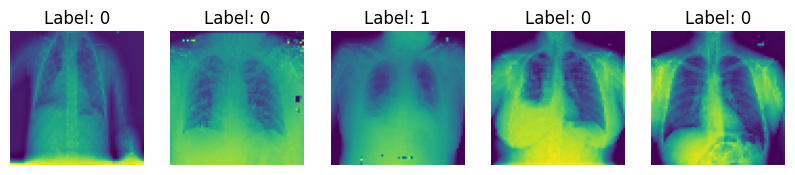

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


35/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7118 - loss: 0.6275

W0000 00:00:1715951111.375215    3046 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7469 - loss: 0.6065 - val_accuracy: 0.9000 - val_loss: 0.4024
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8953 - loss: 0.3833 - val_accuracy: 0.9000 - val_loss: 0.3252
Epoch 3/10


W0000 00:00:1715951111.975085    3048 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9111 - loss: 0.3093 - val_accuracy: 0.9000 - val_loss: 0.3182
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9093 - loss: 0.3092 - val_accuracy: 0.9000 - val_loss: 0.3179
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9018 - loss: 0.3216 - val_accuracy: 0.9000 - val_loss: 0.3179
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8916 - loss: 0.3450 - val_accuracy: 0.9000 - val_loss: 0.3179
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9025 - loss: 0.3150 - val_accuracy: 0.9000 - val_loss: 0.3179
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9083 - loss: 0.3006 - val_accuracy: 0.9000 - val_loss: 0.3177
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8787 - loss: 0.3670 - val_accuracy: 0.9000 - val_loss: 0.3171
Epoch 10/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9251 - loss: 0.2672 - val_accuracy: 0.9000 - val_loss: 0.3172
7/

W0000 00:00:1715951114.398304    3045 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [45]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)
plot_images(X_train,Y_train)
# Define the model
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(64, (3,3), input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 2
model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer
model.add(Flatten())

# Dense layer 1
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Specify optimizer and compile the model
optimizer = Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_split=0.1)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


In [46]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import math

# Ensure normalization of data
X1 = X1 / 255.0  # Normalizing data
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def build_model(hp):
    model = Sequential()

    # Convolutional layer 1
    model.add(Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        input_shape=X_train.shape[1:]
    ))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional layer 2
    model.add(Conv2D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5])
    ))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional layer 3
    model.add(Conv2D(
        filters=hp.Int('conv_3_filter', min_value=128, max_value=512, step=128),
        kernel_size=hp.Choice('conv_3_kernel', values=[3, 5])
    ))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Dense layer 1
    model.add(Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1_rate', min_value=0.3, max_value=0.7, step=0.1)))

    # Dense layer 2
    model.add(Dense(
        units=hp.Int('dense_2_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Increased number of trials
    executions_per_trial=4,  # Increase executions per trial
    directory='my_dir',
    project_name='hyperparam_tuning'
)

# Display search space summary
tuner.search_space_summary()

# Search for the best hyperparameter configuration
tuner.search(datagen.flow(X_train, Y_train, batch_size=32), 
             steps_per_epoch=math.ceil(len(X_train) / 32),
             epochs=10, 
             validation_data=(X_test, Y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first dense layer is {best_hps.get('dense_1_units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)

# Early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Train the model with the best hyperparameters
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32), 
                    steps_per_epoch=math.ceil(len(X_train) / 32),
                    epochs=32,
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Reloading Tuner from my_dir/hyperparam_tuning/tuner0.json
Search space summary
Default search space size: 10
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dropout_1_rate (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.3, 'max_value': 0.7, 'step': 0.1, 'sampli

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6144 - loss: 0.7557

W0000 00:00:1715951123.302921    3046 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6399 - loss: 0.7171

W0000 00:00:1715951124.441542    3047 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.6409 - loss: 0.7150 - val_accuracy: 0.9200 - val_loss: 0.6284 - learning_rate: 1.0000e-05
Epoch 2/32
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9200 - val_loss: 0.6284 - learning_rate: 1.0000e-05
Epoch 3/32


W0000 00:00:1715951125.166473    3047 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7562 - loss: 0.5238 - val_accuracy: 0.9200 - val_loss: 0.5708 - learning_rate: 1.0000e-05
Epoch 4/32
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9200 - val_loss: 0.5708 - learning_rate: 1.0000e-05
Epoch 5/32
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8215 - loss: 0.4858 - val_accuracy: 0.9200 - val_loss: 0.5211 - learning_rate: 1.0000e-05
Epoch 6/32
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9200 - val_loss: 0.5211 - learning_rate: 1.0000e-05
Epoch 7/32
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8540 - loss: 0.4134 - val_accuracy: 0.9200 - val_loss: 0.4823 - learning_rate: 1.0000e-05
Epoch 8/32
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9200 - val_loss: 0.4823 - learning_rate: 1.0000e-05
Epoch 9/32
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accurac

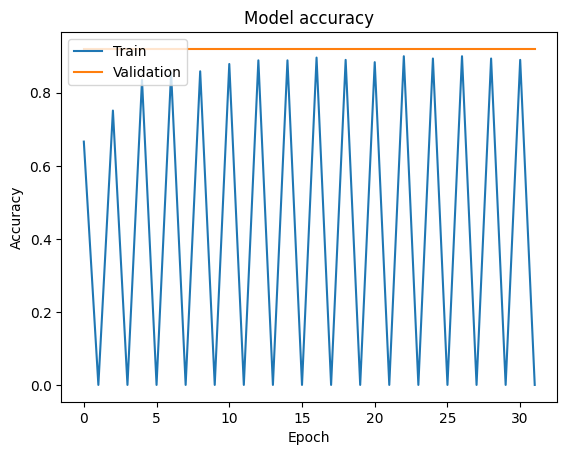

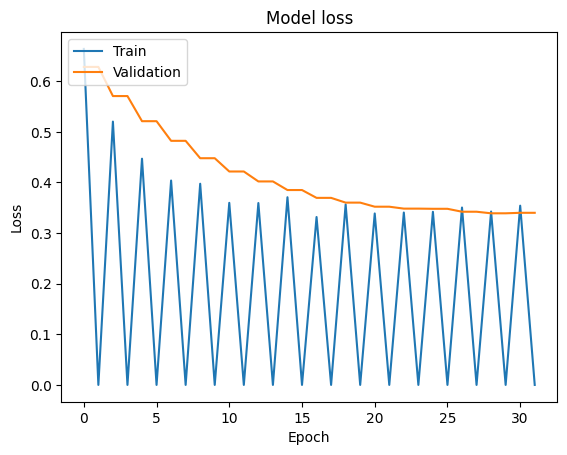

In [47]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


1/7 ━━━━━━━━━━━━━━━━━━━━ 2s 484ms/step

W0000 00:00:1715951137.717027    3046 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


W0000 00:00:1715951138.204208    3046 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


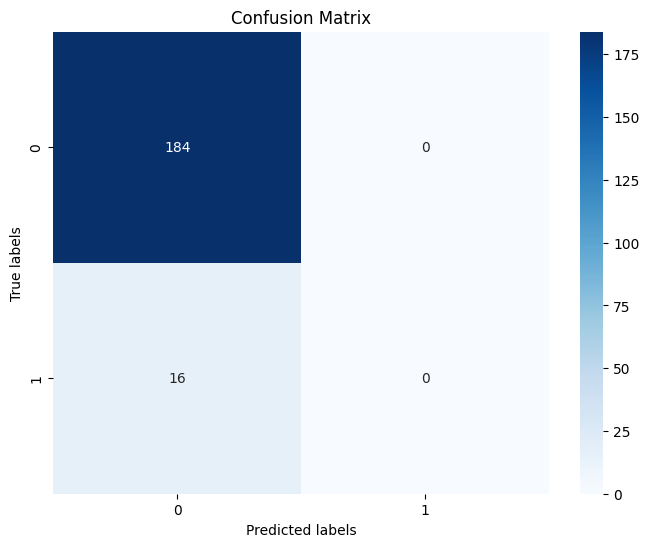

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict probabilities for the test set
Y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
Y_pred = (Y_pred_probs > 0.5).astype("int32")

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [49]:
import numpy as np

# Convert grayscale images to RGB
X_train_rgb = np.repeat(X_train, 3, -1)
X_test_rgb = np.repeat(X_test, 3, -1)


In [50]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model to train
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)


# Convert grayscale images to RGB
X_train_rgb = np.repeat(X_train, 3, -1)
X_test_rgb = np.repeat(X_test, 3, -1)


# Train the model
history = model.fit(X_train_rgb, Y_train, batch_size=16, epochs=5, validation_split=0.1)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test_rgb, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 104ms/step - accuracy: 0.9023 - loss: 0.3766 - val_accuracy: 0.9000 - val_loss: 0.3276
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9139 - loss: 0.2944 - val_accuracy: 0.9000 - val_loss: 0.3261
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8903 - loss: 0.3509 - val_accuracy: 0.9000 - val_loss: 0.3256
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8984 - loss: 0.3308 - val_accuracy: 0.9000 - val_loss: 0.3268
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9051 - loss: 0.3160 - val_accuracy: 0.9000 - val_loss: 0.3254
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 527ms/step - accuracy: 0.9111 - loss: 0.3002
Test Loss: 0.2798144817352295
Test Accuracy: 0.9200000166893005


In [51]:
# Make predictions
predictions = model.predict(X_test_rgb)

# Round predictions to 0 or 1
rounded_predictions = np.round(predictions)

# Evaluate model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(Y_test, rounded_predictions)
print("Accuracy:", accuracy)


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 633ms/step
Accuracy: 0.92


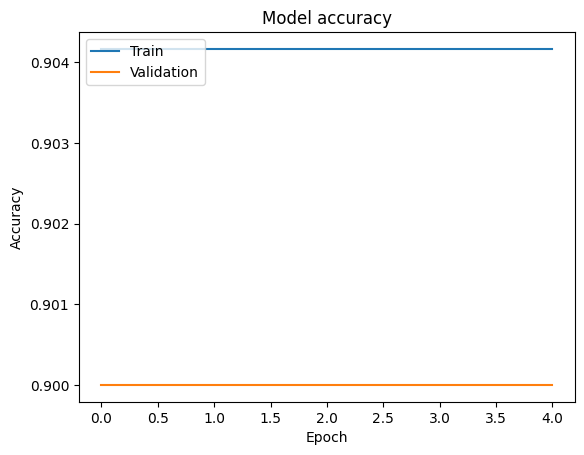

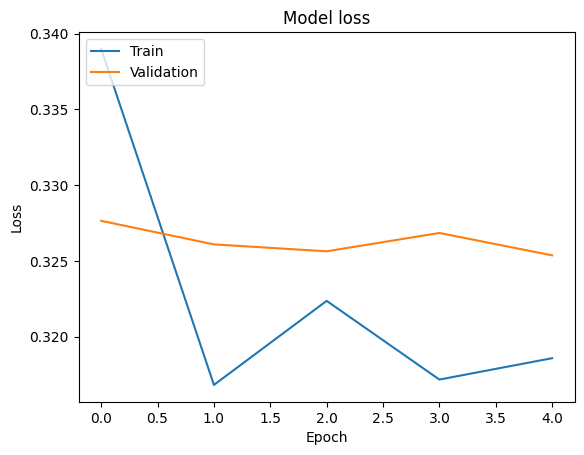

In [52]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


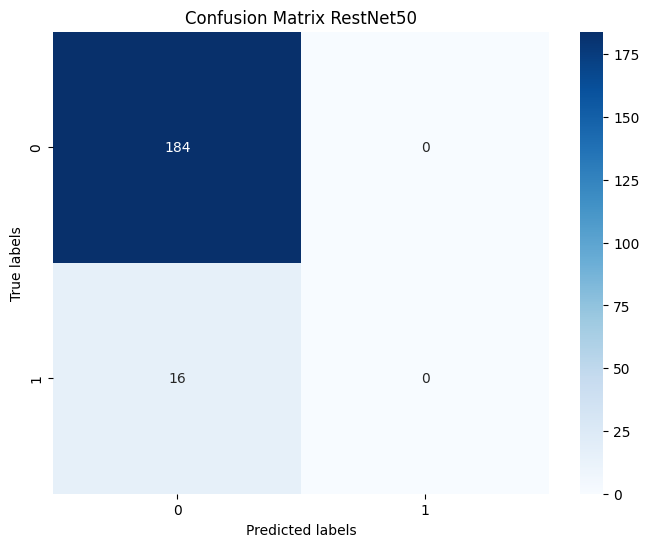

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict probabilities for the test set
Y_pred_probs = model.predict(X_test_rgb)

# Convert probabilities to class labels
Y_pred = (Y_pred_probs > 0.5).astype("int32")

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix RestNet50')
plt.show()


In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns

def create_alexnet(input_shape):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    
    # Layer 1
    model.add(Conv2D(96, (11, 11), strides=4, activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    
    # Layer 2
    model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    
    # Layer 3
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming X1 and Y1 are your data and labels, and they are already preprocessed
input_shape = (227, 227, 3)  # Resize images to this shape

# Convert grayscale images to RGB if needed
def convert_to_rgb(images):
    return np.repeat(images[..., np.newaxis], 3, -1)

X1_rgb = convert_to_rgb(X1)  # Assuming X1 is your dataset of grayscale images

# Resize images to 227x227
X1_resized = np.array([np.resize(img, (227, 227, 3)) for img in X1_rgb])

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X1_resized, Y1, test_size=0.2, random_state=42)

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Calculate class weights to handle class imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.5

callback = LearningRateScheduler(scheduler)

# Train AlexNet
alexnet_model = create_alexnet(input_shape)
alexnet_history = alexnet_model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_split=0.1, class_weight=class_weights, callbacks=[callback])

# Evaluate AlexNet
alexnet_loss, alexnet_accuracy = alexnet_model.evaluate(X_test, Y_test)
print(f'AlexNet Test Accuracy: {alexnet_accuracy}')

# Make predictions
alexnet_predictions = (alexnet_model.predict(X_test) > 0.5).astype(int)


Epoch 1/10
 7/45 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7096 - loss: 0.7576

W0000 00:00:1715951190.267907    3046 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.7309 - loss: 0.7204 - val_accuracy: 0.9000 - val_loss: 0.6809 - learning_rate: 0.0010
Epoch 2/10
 4/45 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8255 - loss: 0.6496

W0000 00:00:1715951192.083626    3046 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4538 - loss: 0.7305 - val_accuracy: 0.9000 - val_loss: 0.6292 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8569 - loss: 0.7049 - val_accuracy: 0.9000 - val_loss: 0.6879 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8373 - loss: 0.6434 - val_accuracy: 0.1000 - val_loss: 0.7051 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1596 - loss: 0.7595 - val_accuracy: 0.9000 - val_loss: 0.6813 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6922 - loss: 0.7592 - val_accuracy: 0.9000 - val_loss: 0.6733 - learning_rate: 5.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8075 - loss: 0.7124 - val_accuracy: 0.9000 - val_loss: 0.6774 - learning_rate: 2.5000e-04
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7558 - loss: 0.6997 - val_accura

W0000 00:00:1715951204.600099    3047 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.9111 - loss: 0.6840
AlexNet Test Accuracy: 0.9200000166893005
1/7 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step

W0000 00:00:1715951206.859292    3047 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


AlexNet Accuracy: 0.92
AlexNet F1 Score: 0.0
AlexNet Precision: 0.0
AlexNet Recall: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


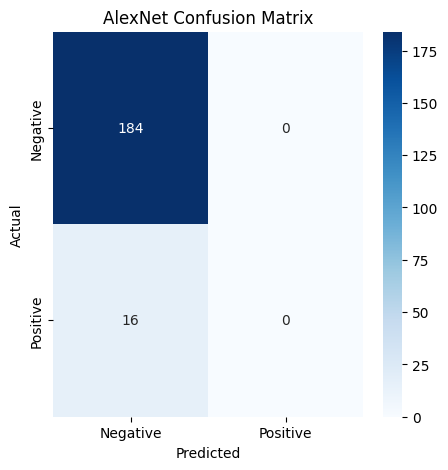

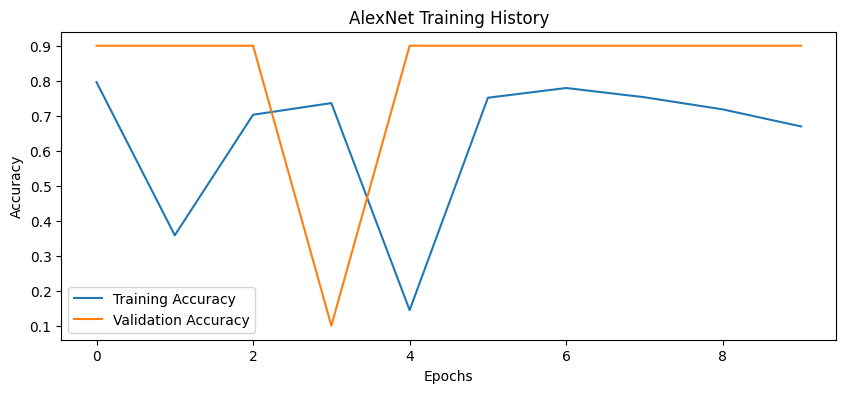

In [55]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Calculate and plot metrics for AlexNet
alexnet_accuracy_score = accuracy_score(Y_test, alexnet_predictions)
alexnet_f1_score = f1_score(Y_test, alexnet_predictions)
alexnet_precision_score = precision_score(Y_test, alexnet_predictions)
alexnet_recall_score = recall_score(Y_test, alexnet_predictions)

print(f'AlexNet Accuracy: {alexnet_accuracy_score}')
print(f'AlexNet F1 Score: {alexnet_f1_score}')
print(f'AlexNet Precision: {alexnet_precision_score}')
print(f'AlexNet Recall: {alexnet_recall_score}')

plot_confusion_matrix(Y_test, alexnet_predictions, 'AlexNet Confusion Matrix')

# Function to plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(alexnet_history, 'AlexNet Training History')


Epoch 1/10


2024-05-17 13:06:58.315259: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20202: 2.55288, expected 2.19091
2024-05-17 13:06:58.315381: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28601: 2.56859, expected 2.20662
2024-05-17 13:06:58.315561: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 51528: 2.40557, expected 2.04359
2024-05-17 13:06:58.316225: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 154587: 3.93731, expected 3.05335
2024-05-17 13:06:58.316255: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 154588: 5.79522, expected 4.91126
2024-05-17 13:06:58.316272: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 154589: 5.75799, expected 4.87403
2024-05-17 13:06:58.316285: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 154590: 5.76868, expected 4.88472
2024-05-17 13:06:58.316

45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9219 - loss: 0.6347 - val_accuracy: 0.9000 - val_loss: 0.6895 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4926 - loss: 0.6926 - val_accuracy: 0.1000 - val_loss: 0.6938 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7331 - loss: 0.6752 - val_accuracy: 0.9000 - val_loss: 0.6918 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7659 - loss: 0.6769 - val_accuracy: 0.1000 - val_loss: 0.6964 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.3616 - loss: 0.7150 - val_accuracy: 0.9000 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.6345 - loss: 0.7130 - val_accuracy: 0.9000 - val_loss: 0.6900 - learning_rate: 5.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7576 - loss: 0.6727 - val_accuracy:

2024-05-17 13:07:33.588301: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.60863, expected 3.02739
2024-05-17 13:07:33.588365: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.83027, expected 3.24903
2024-05-17 13:07:33.588378: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.78016, expected 4.19892
2024-05-17 13:07:33.588391: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.23447, expected 3.65322
2024-05-17 13:07:33.588409: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.69496, expected 4.11371
2024-05-17 13:07:33.588420: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.51646, expected 3.93521
2024-05-17 13:07:33.588431: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 4.67178, expected 4.09053
2024-05-17 13:07:33.588441: E external/local_xla/xla/s

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9064 - loss: 0.6902

2024-05-17 13:07:37.914186: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.30912, expected 3.34002
2024-05-17 13:07:37.914245: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.16936, expected 5.20026
2024-05-17 13:07:37.914254: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.38267, expected 4.41358
2024-05-17 13:07:37.914262: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.59712, expected 5.62803
2024-05-17 13:07:37.914269: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.15746, expected 4.18837
2024-05-17 13:07:37.914277: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.53547, expected 4.56638
2024-05-17 13:07:37.914284: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.84168, expected 5.87259
2024-05-17 13:07:37.914291: E external/local_xla/xla/se

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - accuracy: 0.9111 - loss: 0.6902


W0000 00:00:1715951260.060607    3048 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


DarkNet-19 Test Accuracy: 0.9200000166893005
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
DarkNet-19 Accuracy: 0.92
DarkNet-19 F1 Score: 0.0
DarkNet-19 Precision: 0.0
DarkNet-19 Recall: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


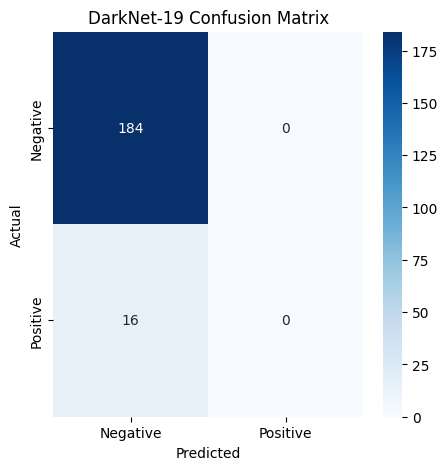

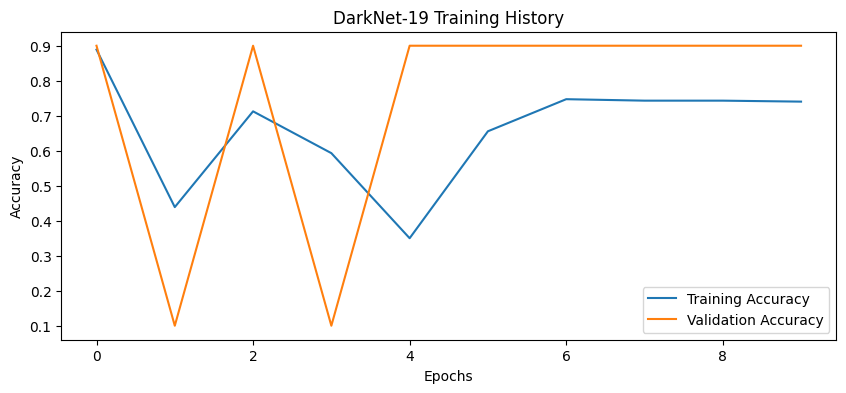

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns

def create_darknet19(input_shape):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    
    # Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (1, 1), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 4
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (1, 1), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (1, 1), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (1, 1), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 6
    model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (1, 1), activation='relu', padding='same'))
    model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (1, 1), activation='relu', padding='same'))
    model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming X1 and Y1 are your data and labels, and they are already preprocessed
input_shape = (227, 227, 3)  # Resize images to this shape

# Convert grayscale images to RGB if needed
def convert_to_rgb(images):
    return np.repeat(images[..., np.newaxis], 3, -1)

X1_rgb = convert_to_rgb(X1)  # Assuming X1 is your dataset of grayscale images

# Resize images to 227x227
X1_resized = np.array([np.resize(img, (227, 227, 3)) for img in X1_rgb])

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X1_resized, Y1, test_size=0.2, random_state=42)

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Calculate class weights to handle class imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.5

callback = LearningRateScheduler(scheduler)

# Train DarkNet-19
darknet19_model = create_darknet19(input_shape)
darknet19_history = darknet19_model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_split=0.1, class_weight=class_weights, callbacks=[callback])

# Evaluate DarkNet-19
darknet19_loss, darknet19_accuracy = darknet19_model.evaluate(X_test, Y_test)
print(f'DarkNet-19 Test Accuracy: {darknet19_accuracy}')

# Make predictions
darknet19_predictions = (darknet19_model.predict(X_test) > 0.5).astype(int)

# Plot confusion matrix and training history for DarkNet-19
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

darknet19_accuracy_score = accuracy_score(Y_test, darknet19_predictions)
darknet19_f1_score = f1_score(Y_test, darknet19_predictions)
darknet19_precision_score = precision_score(Y_test, darknet19_predictions)
darknet19_recall_score = recall_score(Y_test, darknet19_predictions)

print(f'DarkNet-19 Accuracy: {darknet19_accuracy_score}')
print(f'DarkNet-19 F1 Score: {darknet19_f1_score}')
print(f'DarkNet-19 Precision: {darknet19_precision_score}')
print(f'DarkNet-19 Recall: {darknet19_recall_score}')

plot_confusion_matrix(Y_test, darknet19_predictions, 'DarkNet-19 Confusion Matrix')

def plot_training_history(history, title):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(darknet19_history, 'DarkNet-19 Training History')


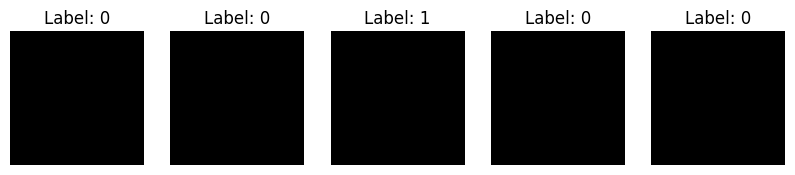

In [57]:

# Plot some images
plot_images(X_train, Y_train)



Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6146 - loss: 0.6834 - val_accuracy: 0.9000 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5783 - loss: 0.6961 - val_accuracy: 0.9000 - val_loss: 0.6865 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8553 - loss: 0.6748 - val_accuracy: 0.9000 - val_loss: 0.6814 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7026 - loss: 0.7119 - val_accuracy: 0.9000 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8599 - loss: 0.6639 - val_accuracy: 0.9000 - val_loss: 0.6872 - learning_rate: 0.0010
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7583 - loss: 0.7574 - val_accuracy: 0.9000 - val_loss: 0.6917 - learning_rate: 5.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6465 - loss: 0.7342 - val_accur

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


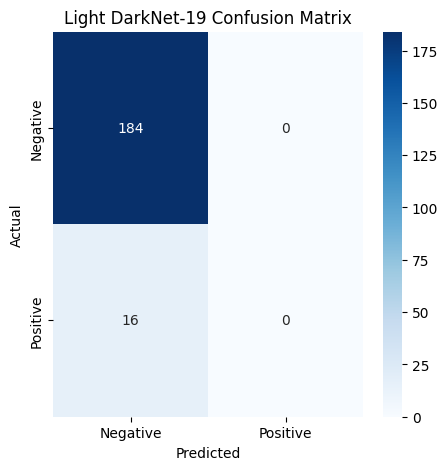

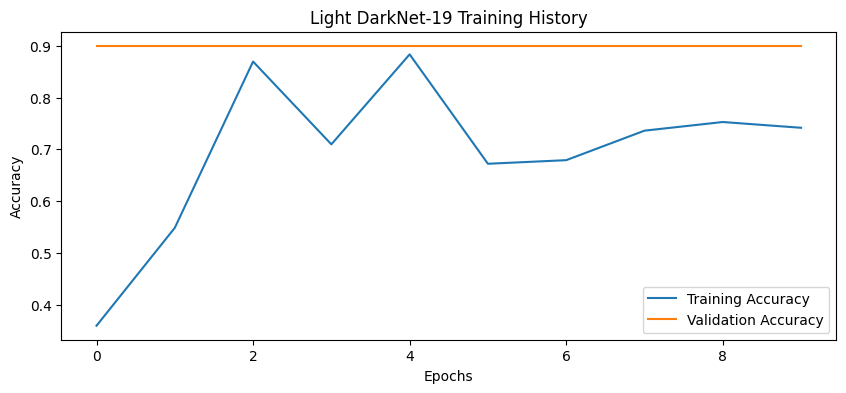

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

def create_light_darknet19(input_shape):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    
    # Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (1, 1), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 4
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (1, 1), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (1, 1), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming X1 and Y1 are your data and labels, and they are already preprocessed
input_shape = (64, 64, 1)  # Resize images to this shape

# Resize images to 64x64
X1_resized = np.array([cv2.resize(img, (64, 64)) for img in X1])

# Expand dimensions to fit the input shape (64, 64, 1)
X1_resized = X1_resized[..., np.newaxis]

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X1_resized, Y1, test_size=0.2, random_state=42)

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0
from imblearn.over_sampling import RandomOverSampler



# Calculate class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.5

callback = LearningRateScheduler(scheduler)

# Train the light DarkNet-19 model
light_darknet19_model = create_light_darknet19(input_shape)
light_darknet19_history = light_darknet19_model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_split=0.1, class_weight=class_weights, callbacks=[callback])

# Evaluate the light DarkNet-19 model
light_darknet19_loss, light_darknet19_accuracy = light_darknet19_model.evaluate(X_test, Y_test)
print(f'Light DarkNet-19 Test Accuracy: {light_darknet19_accuracy}')

# Make predictions
light_darknet19_predictions = (light_darknet19_model.predict(X_test) > 0.5).astype(int)

# Plot confusion matrix and training history for the light DarkNet-19
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

light_darknet19_accuracy_score = accuracy_score(Y_test, light_darknet19_predictions)
light_darknet19_f1_score = f1_score(Y_test, light_darknet19_predictions)
light_darknet19_precision_score = precision_score(Y_test, light_darknet19_predictions)
light_darknet19_recall_score = recall_score(Y_test, light_darknet19_predictions)

print(f'Light DarkNet-19 Accuracy: {light_darknet19_accuracy_score}')
print(f'Light DarkNet-19 F1 Score: {light_darknet19_f1_score}')
print(f'Light DarkNet-19 Precision: {light_darknet19_precision_score}')
print(f'Light DarkNet-19 Recall: {light_darknet19_recall_score}')

plot_confusion_matrix(Y_test, light_darknet19_predictions, 'Light DarkNet-19 Confusion Matrix')

def plot_training_history(history, title):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(light_darknet19_history, 'Light DarkNet-19 Training History')
                      
    


In [23]:
from imblearn.over_sampling import RandomOverSampler
# Assuming X_train and Y_train are your training data and labels
ros = RandomOverSampler(sampling_strategy='minority')
X_train_resampled, Y_train_resampled = ros.fit_resample(X_train.reshape(-1, 64*64*1), Y_train)
X_train_resampled = X_train_resampled.reshape(-1, 64, 64, 1)

# Train the model with the resampled data
light_darknet19_model = create_light_darknet19(input_shape)
light_darknet19_history = light_darknet19_model.fit(X_train_resampled, Y_train_resampled, batch_size=16, epochs=10, validation_split=0.1, class_weight=class_weights, callbacks=[callback])


Epoch 1/10
406/407 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4463 - loss: 1.0650

2024-05-17 12:30:44.683144: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.9335, expected 1.35353
2024-05-17 12:30:44.683208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.79156, expected 2.2116
2024-05-17 12:30:44.683222: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.65692, expected 2.07695
2024-05-17 12:30:44.683235: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.38531, expected 1.80535
2024-05-17 12:30:44.683253: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.55576, expected 1.97579
2024-05-17 12:30:44.683264: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.13249, expected 2.55252
2024-05-17 12:30:44.683274: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.22547, expected 3.64551
2024-05-17 12:30:44.683284: E external/local_xla/xla/serv

407/407 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4463 - loss: 1.0648

2024-05-17 12:30:49.877941: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4096: 1.85192, expected 1.01295
2024-05-17 12:30:49.878005: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4097: 2.72421, expected 1.88525
2024-05-17 12:30:49.878015: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4098: 2.69384, expected 1.85487
2024-05-17 12:30:49.878025: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4099: 1.85031, expected 1.01134
2024-05-17 12:30:49.878032: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4100: 3.19798, expected 2.35901
2024-05-17 12:30:49.878039: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4101: 2.90824, expected 2.06927
2024-05-17 12:30:49.878047: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4102: 3.52066, expected 2.68169
2024-05-17 12:30:49.878054: E exte

407/407 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4463 - loss: 1.0646 - val_accuracy: 1.0000 - val_loss: 0.1341 - learning_rate: 0.0010
Epoch 2/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4309 - loss: 0.9662 - val_accuracy: 1.0000 - val_loss: 0.1226 - learning_rate: 0.0010
Epoch 3/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4488 - loss: 0.9972 - val_accuracy: 1.0000 - val_loss: 0.1227 - learning_rate: 0.0010
Epoch 4/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4386 - loss: 2.3735 - val_accuracy: 1.0000 - val_loss: 0.0967 - learning_rate: 0.0010
Epoch 5/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4337 - loss: 31.3689 - val_accuracy: 1.0000 - val_loss: 0.1611 - learning_rate: 0.0010
Epoch 6/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4457 - loss: 1.0990 - val_accuracy: 1.0000 - val_loss: 0.0994 - learning_rate: 5.0000e-04
Epoch 7/10
407/407 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4427 - loss: 1.2163 - val_

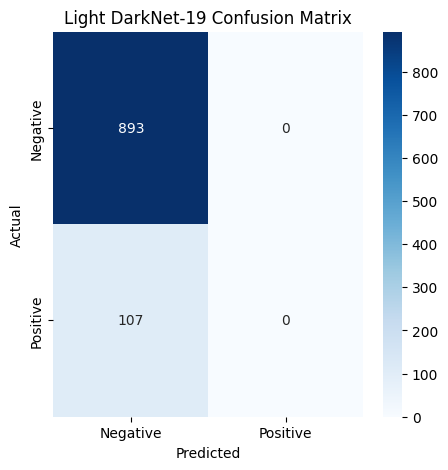

In [24]:
# Plot confusion matrix
plot_confusion_matrix(Y_test, light_darknet19_predictions, 'Light DarkNet-19 Confusion Matrix')


In [25]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(Y_test, light_darknet19_model.predict(X_test))
print(f'Light DarkNet-19 ROC-AUC Score: {roc_auc}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Light DarkNet-19 ROC-AUC Score: 0.5171950058084165


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 16/407 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4639 - loss: 1.8281

W0000 00:00:1715950736.424869    3047 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


407/407 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.4851 - loss: 1.1127 - val_accuracy: 0.0900 - val_loss: 2.1999 - learning_rate: 1.0000e-04
Epoch 2/50
  6/407 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4845 - loss: 0.9192 

W0000 00:00:1715950744.762666    3045 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4998 - loss: 0.9297 - val_accuracy: 0.0900 - val_loss: 1.9914 - learning_rate: 1.0000e-04
Epoch 3/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4900 - loss: 0.9127 - val_accuracy: 0.0900 - val_loss: 2.0764 - learning_rate: 1.0000e-04
Epoch 4/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5045 - loss: 0.8621 - val_accuracy: 0.0900 - val_loss: 1.9656 - learning_rate: 1.0000e-04
Epoch 5/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4899 - loss: 0.8653 - val_accuracy: 0.0900 - val_loss: 1.7935 - learning_rate: 1.0000e-04
Epoch 6/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5059 - loss: 0.8579 - val_accuracy: 0.0900 - val_loss: 1.8931 - learning_rate: 1.0000e-04
Epoch 7/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4940 - loss: 0.8553 - val_accuracy: 0.0900 - val_loss: 1.5967 - learning_rate: 1.0000e-04
Epoch 8/50
407/407 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.49

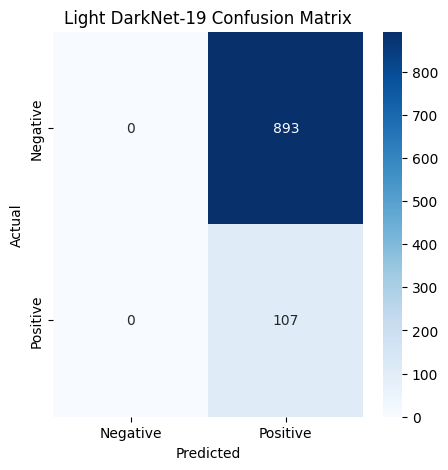

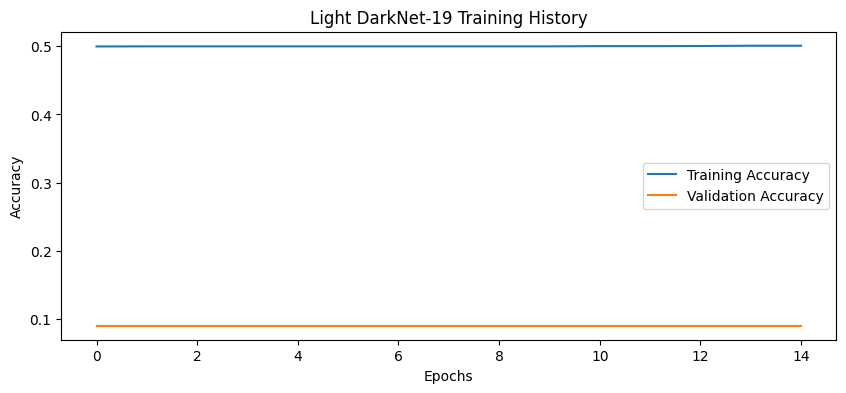

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler

def create_light_darknet19(input_shape):
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=input_shape))
    
    # Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 4
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming X1 and Y1 are your data and labels, and they are already preprocessed
input_shape = (64, 64, 1)  # Resize images to this shape

# Resize images to 64x64
X1_resized = np.array([cv2.resize(img, (64, 64)) for img in X1])

# Expand dimensions to fit the input shape (64, 64, 1)
X1_resized = X1_resized[..., np.newaxis]

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X1_resized, Y1, test_size=0.2, random_state=42)

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Calculate class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Learning rate scheduler and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Apply RandomOverSampler
X_train_flat = X_train.reshape(-1, 64*64*1)
ros = RandomOverSampler(sampling_strategy='minority')
X_train_resampled, Y_train_resampled = ros.fit_resample(X_train_flat, Y_train)
X_train_resampled = X_train_resampled.reshape(-1, 64, 64, 1)

# Fit the model
light_darknet19_model = create_light_darknet19(input_shape)
light_darknet19_history = light_darknet19_model.fit(
    datagen.flow(X_train_resampled, Y_train_resampled, batch_size=16),
    validation_data=(X_val, Y_val),
    epochs=50,
    class_weight=class_weights,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the light DarkNet-19 model
light_darknet19_loss, light_darknet19_accuracy = light_darknet19_model.evaluate(X_test, Y_test)
print(f'Light DarkNet-19 Test Accuracy: {light_darknet19_accuracy}')

# Make predictions
light_darknet19_predictions = (light_darknet19_model.predict(X_test) > 0.5).astype(int)

# Calculate ROC-AUC Score
roc_auc = roc_auc_score(Y_test, light_darknet19_model.predict(X_test))
print(f'Light DarkNet-19 ROC-AUC Score: {roc_auc}')

# Plot confusion matrix and training history for the light DarkNet-19
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

light_darknet19_accuracy_score = accuracy_score(Y_test, light_darknet19_predictions)
light_darknet19_f1_score = f1_score(Y_test, light_darknet19_predictions)
light_darknet19_precision_score = precision_score(Y_test, light_darknet19_predictions)
light_darknet19_recall_score = recall_score(Y_test, light_darknet19_predictions)

print(f'Light DarkNet-19 Accuracy: {light_darknet19_accuracy_score}')
print(f'Light DarkNet-19 F1 Score: {light_darknet19_f1_score}')
print(f'Light DarkNet-19 Precision: {light_darknet19_precision_score}')
print(f'Light DarkNet-19 Recall: {light_darknet19_recall_score}')

plot_confusion_matrix(Y_test, light_darknet19_predictions, 'Light DarkNet-19 Confusion Matrix')

def plot_training_history(history, title):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(light_darknet19_history, 'Light DarkNet-19 Training History')
